# Demonstration notebook for the BOA process estimation.

In [1]:
import numpy as np
from matplotlib.pyplot import *

import src.initialization
import src.simulation
import src.estimation
import src.postprocessing

## Generating a synthetic data set

We start by defining the initial state of the seed bank. This is done through the `src.initialization` module, which provides several initializers.

Here, we use a random initialization:

In [2]:
N = 100 # Number of tree bases
H = 2 # Maximal seed dormancy

np.random.seed(0)
init = src.initialization.init_random(N=N, H=H, s=0.3)

The initial state of the seed bank is given by the age of the seeds in each tree patch.

Next, this initial state is used to generate a trajectory of the BOA process, using `src.simulation.simulate`:

In [3]:
p_ext = 0.8 # local extinction probability
T = 100 # number of observation years

np.random.seed(0)
O, C, E = src.simulation.simulate(p_ext=p_ext, H=H, N=N, T=T, init=init)

We obtain three variables:
- A binary matrix of observations `O`
- The matrix `C` giving the age of the seeds at each time and each tree base
- The binary matrix `E`, specifying whether an extinction event happened at each time and tree base.

**Note**: in order to keep this demonstration simple, we simulate and estimate the non-noisy BOA process, i.e., we keep the variable `eps` equal to its default null value.

The trajectory of the BOA process can be vizualized in a picture as below, where the yellow pixels denote the presence of the plant species.

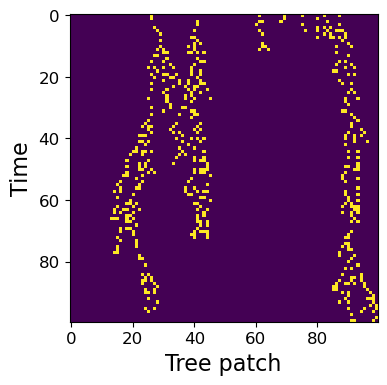

In [4]:
figure(figsize=(4,4))
xlabel("Tree patch", fontsize=16); ylabel("Time", fontsize=16)
xticks(fontsize=12); yticks(fontsize=12)
imshow(O)
show()

In what follows, we assume that we only know the observations `O`, and we wish to estimate the parameters of the model.

We restrict ourselves to the 10 first observation years, since allowing 100 observation years makes the estimation problem too simple:

In [5]:
O = O[:10]

## Estimating the parameters of the BOA process

We run the estimation procedure for 10000 iterations, imposing that the maximal seed dormancy remains below 10.

In [6]:
estimation_result = src.estimation.estimate_single_street(
    O, H_max=10, niter=10000, noisy_BOA=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

Acceptance rates on (p_ext, H, s, L):
0.37 0.18 0.33 0.35


The result is a Python dictionary, which contains the MCMC samples for each of the model variables. It also has a `log_lk` key, which records the complete model log-likelihood throughout the MCMC convergence.

In [7]:
print(estimation_result.keys())

dict_keys(['p_ext', 'H', 's', 'L', 'log_lk'])


The convergence of the MCMC can be visually inspected simply:

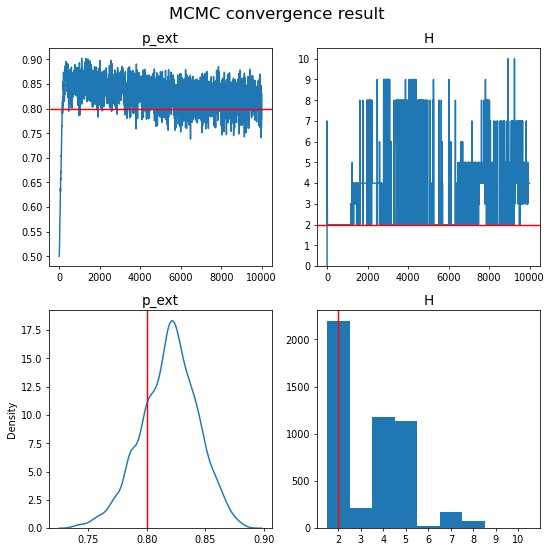

In [8]:
src.postprocessing.plot_convergence(estimation_result, 
                                    p_ext_true=p_ext, H_true=H) # optional arguments

## Processing the estimation result

Next, we shorten the estimation result to keep only the last half of the MCMC samples, ensuring that the chain has converged.

In [9]:
estimation_result = src.postprocessing.simplify_history(
    estimation_result, keep_length=5000)

Then, we summarize the estimation result into a dictionnary of metrics:

In [10]:
summary = src.postprocessing.compute_summary(estimation_result)

for key in summary:
    print(key, ":", summary[key])

H_inf : 2
p(H=0) : 0.0
p(H=1) : 0.0
p(H=2) : 0.4394
p(H=3) : 0.0418
p(H=4) : 0.2362
p(H=5) : 0.227
p(H=6) : 0.0042
p(H=7) : 0.0344
p(H=8) : 0.0148
p(H=9) : 0.001
p(H=10) : 0.0012
s_0_mean : 0.9998787316541168
s_1_mean : 0.9999978780785359
s_2_mean : 0.3621762941363625
s_3_mean : 0.3417045667186401
s_4_mean : 0.17867822287317967
s_5_mean : 0.15721242413179906
s_6_mean : 0.2260771040431923
s_7_mean : 0.16971502610713504
s_8_mean : 0.18451191883923493
s_9_mean : 0.20674658236619517
s_10_mean : 0.28263722558720344
p_ext_mean : [0.81929816]
p_ext_std : [0.02420214]
GER : [0.5648]
MaxGER : [0.99908967]
log_lk : -1000.1731191919021


The `summary` variable contains the following information:
- The GER and MaxGER metrics for quantifying the extinction risk
- The model complete likelihood (`log_lk`)
- The posterior distribution of `H`, given by the keys `p(H=0)`, `p(H=1)`, ...
- The value of `H_inf` (5% quantile of the posterior distribution of H)
- For all continuous model parameters (`p_ext`, `s`, `eps` for the noisy BOA), the posterior mean. The posterior distribution of `s` is computed conditionally to each possible value of `H` (e.g., `s_5_mean` is the posterior mean of s given the observations and `H=5`).

Finally, we can display the posterior distribution of the two main parameters `H` and `p_ext`:

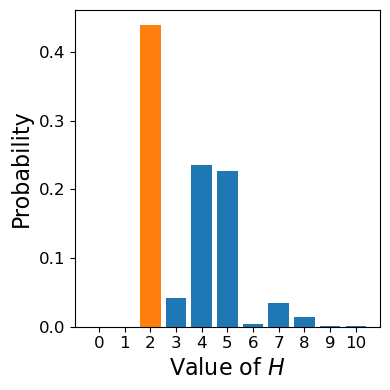

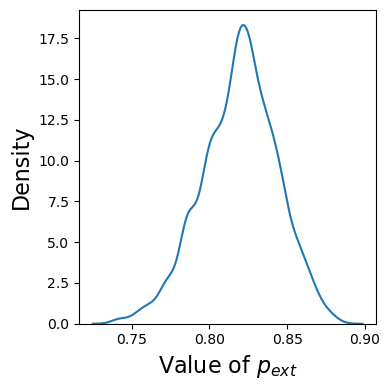

In [11]:
# The orange bar in the first plot represents H_inf
src.postprocessing.plot_posterior(estimation_result, summary, plot_size=4)

In [12]:
print(summary["MaxGER"])

[0.99908967]


The MaxGER metric gives a value close to 1, meaning that all the posterior samples of `p_ext` fall above the critical value `p_c[H_inf]`.

In [13]:
p_c = np.loadtxt("src/critical_prob.csv", skiprows=1, delimiter=",")[:,1]
H_inf = summary["H_inf"]
print(p_c[H_inf])

0.743


This means that, without exernal colonization, the BOA process will go extinct almost surely. This result is illustrated in the first figure of the notebook, which shows the BOA trajectory up to year 100, where the population hardly survives.